## Install required libraries

In [1]:
!pip install obonet networkx

In [2]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg


In [3]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.5 MB/s eta 0:00:0000:0100:01


## Import required modules

In [4]:
import numpy as np
import pandas as pd
import os
import duckdb as dd
import polars as pl
import h5py
import networkx as nx
import obonet as ob

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

## Separating out the GO terms based on Ontology roots

In [5]:
def separate_go_terms_by_namespace(graph):
    """
    Separates GO terms from a networkx graph into BP, CC, and MF categories.

    Args:
        graph: A networkx MultiDiGraph loaded with obonet.

    Returns:
        A dictionary containing lists of GO term IDs for each namespace.
    """
    bp_terms = []
    cc_terms = []
    mf_terms = []

    # Iterate through every node in the graph, accessing its ID (node_id) and attributes (data)
    for node_id, data in graph.nodes(data=True):
        # The namespace is stored in the 'namespace' key of the node's data dictionary
        namespace = data.get('namespace')

        if namespace == 'biological_process':
            bp_terms.append(node_id)
        elif namespace == 'cellular_component':
            cc_terms.append(node_id)
        elif namespace == 'molecular_function':
            mf_terms.append(node_id)

    return {
        'BP': bp_terms,
        'CC': cc_terms,
        'MF': mf_terms
    }

## Load the Gene Ontology (GO) basic OBO file from the OBO Library

In [6]:
go_file_path = '/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo'
print(f"Loading Gene Ontology from {go_file_path}...")
go_graph = ob.read_obo(go_file_path)
print(f"Total terms loaded: {len(go_graph)}")

Loading Gene Ontology from /kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo...
Total terms loaded: 40122


## Separate the terms

In [7]:
separated_terms = separate_go_terms_by_namespace(go_graph)

In [8]:
print("\nGO Term Counts by Namespace:")
print(f"Biological Process (BP): {len(separated_terms['BP'])} terms")
print(f"Cellular Component (CC): {len(separated_terms['CC'])} terms")
print(f"Molecular Function (MF): {len(separated_terms['MF'])} terms")

print("\nFirst 5 Cellular Component (CC) terms:")
for term_id in separated_terms['CC'][:5]:
    # You can get the human-readable name using the graph data dictionary
    name = go_graph.nodes[term_id].get('name')
    print(f"- {term_id}: {name}")


GO Term Counts by Namespace:
Biological Process (BP): 25950 terms
Cellular Component (CC): 4041 terms
Molecular Function (MF): 10131 terms

First 5 Cellular Component (CC) terms:
- GO:0000015: phosphopyruvate hydratase complex
- GO:0000109: nucleotide-excision repair complex
- GO:0000110: nucleotide-excision repair factor 1 complex
- GO:0000111: nucleotide-excision repair factor 2 complex
- GO:0000112: nucleotide-excision repair factor 3 complex


## Roots of the three ontologies

In [ ]:
go_graph_edges = list(go_graph.edges)

#print(go_graph_edges[0])
print(go_graph.nodes["GO:0008150"])
print("*************")
print(go_graph.nodes["GO:0005575"])
print("*************")
print(go_graph.nodes["GO:0003674"])

In [9]:
depths_from_bp_root = nx.shortest_path_length(go_graph, target="GO:0008150")
depths_from_cc_root = nx.shortest_path_length(go_graph, target="GO:0005575")
depths_from_mf_root = nx.shortest_path_length(go_graph, target="GO:0003674")

In [10]:
print("Max depth of BP ontology -> ",max(depths_from_bp_root.values()))
print("Max depth of CC ontology -> ",max(depths_from_cc_root.values()))
print("Max depth of MF ontology -> ",max(depths_from_mf_root.values()))

Max depth of BP ontology ->  11
Max depth of CC ontology ->  9
Max depth of MF ontology ->  10


In [11]:
cc_terms_at_depths = {}

for i in set(depths_from_cc_root.values()):
    cc_terms_at_depths[i] = [key for key, value in depths_from_cc_root.items() if value == i]

bp_terms_at_depths = {}

for i in set(depths_from_bp_root.values()):
    bp_terms_at_depths[i] = [key for key, value in depths_from_bp_root.items() if value == i]

mf_terms_at_depths = {}

for i in set(depths_from_mf_root.values()):
    mf_terms_at_depths[i] = [key for key, value in depths_from_mf_root.items() if value == i]

### Look at the number of terms at these depths

In [12]:
for k,v in cc_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(cc_terms_at_depths[k]),k))

1 terms at depth 0
3 terms at depth 1
737 terms at depth 2
1162 terms at depth 3
1187 terms at depth 4
608 terms at depth 5
244 terms at depth 6
74 terms at depth 7
24 terms at depth 8
1 terms at depth 9


### Concatenate the CC terms at depths 0,1,7,8 and 9 since they are very less individually

In [13]:
cc_depths_to_concatenate = [0,1,7,8,9]
concatenated_cc_terms = []

for d in cc_depths_to_concatenate:
    concatenated_cc_terms = concatenated_cc_terms + cc_terms_at_depths[d]

print(len(concatenated_cc_terms))

103


In [14]:
for k,v in mf_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(mf_terms_at_depths[k]),k))

1 terms at depth 0
32 terms at depth 1
183 terms at depth 2
889 terms at depth 3
1905 terms at depth 4
4364 terms at depth 5
1868 terms at depth 6
675 terms at depth 7
163 terms at depth 8
50 terms at depth 9
1 terms at depth 10


### Concatenate the MF terms at depths 0,1,8,9 and 10 since they are very less individually

In [15]:
mf_depths_to_concatenate = [0,1,8,9,10]
concatenated_mf_terms = []

for d in mf_depths_to_concatenate:
    concatenated_mf_terms = concatenated_mf_terms + mf_terms_at_depths[d]

print(len(concatenated_mf_terms))

247


In [16]:
for k,v in bp_terms_at_depths.items():
    print("{0} terms at depth {1}".format(len(bp_terms_at_depths[k]),k))

1 terms at depth 0
21 terms at depth 1
409 terms at depth 2
3163 terms at depth 3
6726 terms at depth 4
7591 terms at depth 5
4539 terms at depth 6
2335 terms at depth 7
880 terms at depth 8
195 terms at depth 9
70 terms at depth 10
20 terms at depth 11


### Concatenate the terms at depths 0,1,9,10 and 11 since they are very less individually

In [17]:
bp_depths_to_concatenate = [0,1,9,10,11]
concatenated_bp_terms = []

for d in bp_depths_to_concatenate:
    concatenated_bp_terms = concatenated_bp_terms + bp_terms_at_depths[d]

print(len(concatenated_bp_terms))

307


## Introduce the ESM2 embeddings of dimension 480

In [18]:
emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/train_protein_features_esm2_480.parquet')
emb_df.shape

(82404, 2)

In [19]:
emb_df.head(5)

protein_accession_id,embedding_arrays
str,"array[f32, 480]"
"""Q8H2B4""","[-0.155396, -0.092102, … 0.036743]"
"""O01836""","[-0.121338, 0.071411, … 0.01651]"
"""Q13309""","[-0.148682, 0.137695, … -0.005337]"
"""Q9UPW5""","[-0.016464, -0.000262, … 0.102783]"
"""P70453""","[-0.175415, 0.082336, … -0.007427]"


## Bring in the training data; proteins and the corresponding GO terms

In [20]:
train_terms_df = pl.read_csv('/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv', separator='\t')
train_terms_df.shape

(537027, 3)

## Introduce the embeddings into the training data

In [21]:
train_terms_w_embeds = dd.sql("select distinct t1.protein_accession_id, t2.term, t2.aspect \
, t1.embedding_arrays as protein_embedding \
from emb_df t1 \
join train_terms_df t2 \
on t1.protein_accession_id = t2.EntryID").pl()

print(train_terms_w_embeds.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(537027, 4)


In [22]:
train_terms_w_embeds.head(3)

protein_accession_id,term,aspect,protein_embedding
str,str,str,"array[f32, 480]"
"""Q6NRK1""","""GO:0051011""","""F""","[-0.0849, 0.053009, … -0.095276]"
"""P09911""","""GO:0005515""","""F""","[-0.087646, 0.060791, … 0.081482]"
"""Q874R3""","""GO:0043161""","""P""","[-0.056824, 0.092834, … 0.087097]"


In [23]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_w_embeds").pl()

uniq_protein_accession_ids
i64
82404


## Create separate dataframes for each root ontology based on their depths

### CC

In [24]:
train_terms_w_embeds_cc_concat = train_terms_w_embeds.filter(pl.col("term").is_in(concatenated_cc_terms))
print("train_terms_w_embeds_cc_concat shape -> ",train_terms_w_embeds_cc_concat.shape)

train_terms_w_embeds_cc_2 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[2]))
print("train_terms_w_embeds_cc_2 shape -> ",train_terms_w_embeds_cc_2.shape)

train_terms_w_embeds_cc_3 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[3]))
print("train_terms_w_embeds_cc_3 shape -> ",train_terms_w_embeds_cc_3.shape)

train_terms_w_embeds_cc_4 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[4]))
print("train_terms_w_embeds_cc_4 shape -> ",train_terms_w_embeds_cc_4.shape)

train_terms_w_embeds_cc_5 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[5]))
print("train_terms_w_embeds_cc_5 shape -> ",train_terms_w_embeds_cc_5.shape)

train_terms_w_embeds_cc_6 = train_terms_w_embeds.filter(pl.col("term").is_in(cc_terms_at_depths[6]))
print("train_terms_w_embeds_cc_6 shape -> ",train_terms_w_embeds_cc_6.shape)

train_terms_w_embeds_cc_concat shape ->  (2125, 4)
train_terms_w_embeds_cc_2 shape ->  (50224, 4)
train_terms_w_embeds_cc_3 shape ->  (47468, 4)
train_terms_w_embeds_cc_4 shape ->  (27910, 4)
train_terms_w_embeds_cc_5 shape ->  (26130, 4)
train_terms_w_embeds_cc_6 shape ->  (3913, 4)


In [25]:
train_terms_w_embeds_bp = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['BP']))
print("train_terms_w_embeds_bp shape -> ",train_terms_w_embeds_bp.shape)

train_terms_w_embeds_cc = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['CC']))
print("train_terms_w_embeds_cc shape -> ",train_terms_w_embeds_cc.shape)

train_terms_w_embeds_mf = train_terms_w_embeds.filter(pl.col("term").is_in(separated_terms['MF']))
print("train_terms_w_embeds_mf shape -> ",train_terms_w_embeds_mf.shape)

train_terms_w_embeds_bp shape ->  (250805, 4)
train_terms_w_embeds_cc shape ->  (157770, 4)
train_terms_w_embeds_mf shape ->  (128452, 4)


## Get the 1500 most frequently occuring GO terms

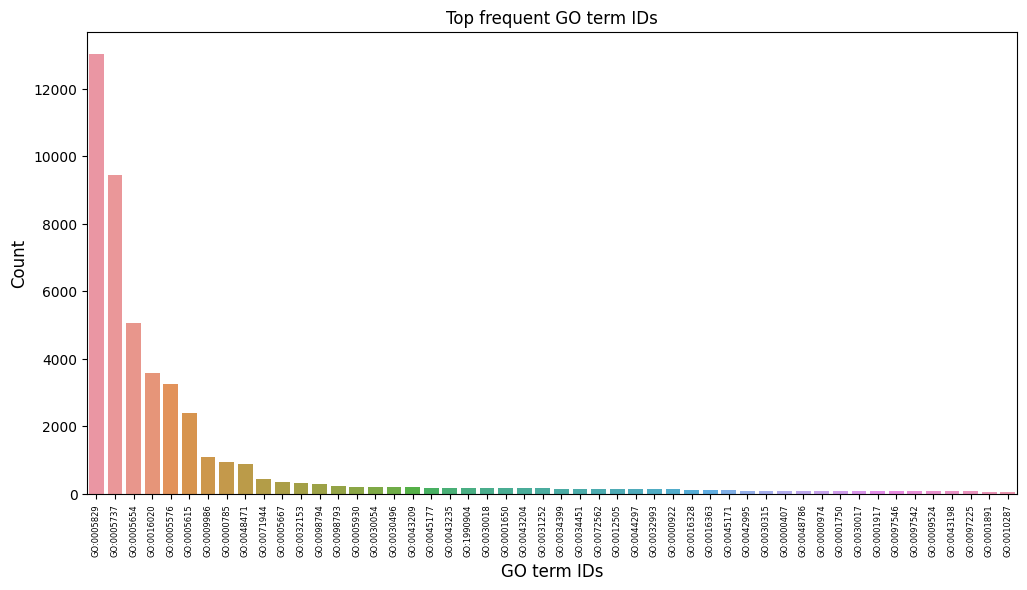

In [29]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_cc_2 group by term order by count(1) desc limit 50").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [ ]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_cc group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [ ]:
plot_df = dd.sql("select term, count(1) as freq from train_terms_w_embeds_mf group by term order by count(1) desc limit 100").pl()
plot_df_pandas = plot_df.to_pandas()

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=plot_df_pandas.term, y=plot_df_pandas.freq)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [28]:
from typing import List

num_of_labels = 1500

def train_labels_per_ontology_pl(input_df: pl.DataFrame, input_num_of_labels: int) -> pl.DataFrame:
    """
    Filters a Polars DataFrame to include only the top N most frequent terms.
    
    Args:
        input_df: The input Polars DataFrame with a 'term' column.
        input_num_of_labels: The number of top terms to keep.
        
    Returns:
        A new Polars DataFrame containing only the top N frequent labels.
    """

    # 1. Calculate the top N frequent terms using Polars methods
    top_labels_df = input_df.group_by("term").count().sort("count", descending=True).limit(input_num_of_labels)
    
    # 2. Extract these top terms into a Python list
    labels_list: List[str] = top_labels_df["term"].to_list()
    
    # 3. Filter the original DataFrame to keep only those terms
    train_labels = input_df.filter(pl.col("term").is_in(labels_list))
    
    print(f"Shape of filtered training data: {train_labels.shape}")
    print("Head of filtered training data:")
    print(train_labels.head())

    return train_labels


In [30]:
train_terms_cc_concat = train_labels_per_ontology_pl(train_terms_w_embeds_cc_concat, 100)
train_terms_cc_2 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_2, 100)
train_terms_cc_3 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_3, 100)
train_terms_cc_4 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_4, 150)
train_terms_cc_5 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_5, 100)
train_terms_cc_6 = train_labels_per_ontology_pl(train_terms_w_embeds_cc_6, 100)

/tmp/ipykernel_38/2248799008.py:18: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  top_labels_df = input_df.group_by("term").count().sort("count", descending=True).limit(input_num_of_labels)


Shape of filtered training data: (2125, 4)
Head of filtered training data:
shape: (5, 4)
┌──────────────────────┬────────────┬────────┬─────────────────────────────────┐
│ protein_accession_id ┆ term       ┆ aspect ┆ protein_embedding               │
│ ---                  ┆ ---        ┆ ---    ┆ ---                             │
│ str                  ┆ str        ┆ str    ┆ array[f32, 480]                 │
╞══════════════════════╪════════════╪════════╪═════════════════════════════════╡
│ P61765               ┆ GO:0032991 ┆ C      ┆ [-0.073486, -0.048492, … 0.059… │
│ Q6ICG8               ┆ GO:0036126 ┆ C      ┆ [-0.14502, -0.030334, … 0.0078… │
│ O43707               ┆ GO:0032991 ┆ C      ┆ [-0.022202, -0.100281, … 0.053… │
│ Q9C093               ┆ GO:0036126 ┆ C      ┆ [-0.046112, -0.065369, … 0.018… │
│ Q9C0D2               ┆ GO:1990498 ┆ C      ┆ [-0.001659, 0.003212, … -0.071… │
└──────────────────────┴────────────┴────────┴─────────────────────────────────┘
Shape of filtered tr

In [31]:
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_concat").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_2").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_3").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_4").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_5").pl())
print(dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from train_terms_cc_6").pl())

shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 2012                       │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 32763                      │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 29980                      │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │
│ ---                        │
│ i64                        │
╞════════════════════════════╡
│ 18007                      │
└────────────────────────────┘
shape: (1, 1)
┌────────────────────────────┐
│ uniq_protein_accession_ids │


In [32]:
train_protein_labels_cc_concat = train_terms_cc_concat.select(['protein_accession_id','term'])
print(train_protein_labels_cc_concat.head(5))

train_protein_labels_cc_2 = train_terms_cc_2.select(['protein_accession_id','term'])
print(train_protein_labels_cc_2.head(5))

train_protein_labels_cc_3 = train_terms_cc_3.select(['protein_accession_id','term'])
print(train_protein_labels_cc_3.head(5))

train_protein_labels_cc_4 = train_terms_cc_4.select(['protein_accession_id','term'])
print(train_protein_labels_cc_4.head(5))

train_protein_labels_cc_5 = train_terms_cc_5.select(['protein_accession_id','term'])
print(train_protein_labels_cc_5.head(5))

train_protein_labels_cc_6 = train_terms_cc_6.select(['protein_accession_id','term'])
print(train_protein_labels_cc_6.head(5))

shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ P61765               ┆ GO:0032991 │
│ Q6ICG8               ┆ GO:0036126 │
│ O43707               ┆ GO:0032991 │
│ Q9C093               ┆ GO:0036126 │
│ Q9C0D2               ┆ GO:1990498 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str                  ┆ str        │
╞══════════════════════╪════════════╡
│ Q00798               ┆ GO:0016020 │
│ P0A8F0               ┆ GO:0005829 │
│ Q64611               ┆ GO:0005737 │
│ P68871               ┆ GO:0005829 │
│ Q9W060               ┆ GO:0000922 │
└──────────────────────┴────────────┘
shape: (5, 2)
┌──────────────────────┬────────────┐
│ protein_accession_id ┆ term       │
│ ---                  ┆ ---        │
│ str   

In [33]:
def get_pivoted_df(input_df: pl.DataFrame) -> pl.DataFrame:
    train_protein_labels_w_term_presence = input_df.with_columns(
        pl.lit(1.0).alias("presence")
    )

    pivoted_df = train_protein_labels_w_term_presence.pivot(
        index="protein_accession_id",
        on="term",
        values="presence",  
        aggregate_function="sum"
    )
    
    pivoted_df = pivoted_df.fill_null(0)
    print(pivoted_df.head(5))
    return pivoted_df

In [34]:
pivoted_df_cc_concat = get_pivoted_df(train_protein_labels_cc_concat)
pivoted_df_cc_2 = get_pivoted_df(train_protein_labels_cc_2)
pivoted_df_cc_3 = get_pivoted_df(train_protein_labels_cc_3)
pivoted_df_cc_4 = get_pivoted_df(train_protein_labels_cc_4)
pivoted_df_cc_5 = get_pivoted_df(train_protein_labels_cc_5)
pivoted_df_cc_6 = get_pivoted_df(train_protein_labels_cc_6)

shape: (5, 71)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ protein_a ┆ GO:003299 ┆ GO:003612 ┆ GO:199049 ┆ … ┆ GO:199072 ┆ GO:009713 ┆ GO:199094 ┆ GO:00975 │
│ ccession_ ┆ 1         ┆ 6         ┆ 8         ┆   ┆ 2         ┆ 2         ┆ 1         ┆ 55       │
│ id        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│ str       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ P61765    ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ Q6ICG8    ┆ 0.0       ┆ 1.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ O43707    ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       

In [35]:
print(pivoted_df_cc_concat.shape)
print(pivoted_df_cc_2.shape)
print(pivoted_df_cc_3.shape)
print(pivoted_df_cc_4.shape)
print(pivoted_df_cc_5.shape)
print(pivoted_df_cc_6.shape)

(2012, 71)
(32763, 101)
(29980, 101)
(18007, 151)
(20171, 101)
(3434, 101)


In [36]:
train_protein_features_cc_concat = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_concat").pl()
print(train_protein_features_cc_concat.head(5))

train_protein_features_cc_2 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_2").pl()
print(train_protein_features_cc_2.head(5))

train_protein_features_cc_3 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_3").pl()
print(train_protein_features_cc_3.head(5))

train_protein_features_cc_4 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_4").pl()
print(train_protein_features_cc_4.head(5))

train_protein_features_cc_5 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_5").pl()
print(train_protein_features_cc_5.head(5))

train_protein_features_cc_6 = dd.sql("select distinct protein_accession_id, protein_embedding from train_terms_cc_6").pl()
print(train_protein_features_cc_6.head(5))

shape: (5, 2)
┌──────────────────────┬─────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding               │
│ ---                  ┆ ---                             │
│ str                  ┆ array[f32, 480]                 │
╞══════════════════════╪═════════════════════════════════╡
│ Q6ICG8               ┆ [-0.14502, -0.030334, … 0.0078… │
│ Q99NH0               ┆ [0.122192, -0.124451, … -0.002… │
│ P62491               ┆ [-0.194336, 0.174438, … -0.148… │
│ P62829               ┆ [-0.108398, -0.130737, … 0.005… │
│ Q16384               ┆ [-0.179688, 0.043701, … -0.036… │
└──────────────────────┴─────────────────────────────────┘
shape: (5, 2)
┌──────────────────────┬─────────────────────────────────┐
│ protein_accession_id ┆ protein_embedding               │
│ ---                  ┆ ---                             │
│ str                  ┆ array[f32, 480]                 │
╞══════════════════════╪═════════════════════════════════╡
│ Q01083               ┆ [-0

In [37]:
pivoted_df_cc_concat.write_parquet('train_protein_labels_cc_concat.parquet')
train_protein_features_cc_concat.write_parquet('train_protein_features_cc_concat.parquet')

pivoted_df_cc_2.write_parquet('train_protein_labels_cc_2.parquet')
train_protein_features_cc_2.write_parquet('train_protein_features_cc_2.parquet')

pivoted_df_cc_3.write_parquet('train_protein_labels_cc_3.parquet')
train_protein_features_cc_3.write_parquet('train_protein_features_cc_3.parquet')

pivoted_df_cc_4.write_parquet('train_protein_labels_cc_4.parquet')
train_protein_features_cc_4.write_parquet('train_protein_features_cc_4.parquet')

pivoted_df_cc_5.write_parquet('train_protein_labels_cc_5.parquet')
train_protein_features_cc_5.write_parquet('train_protein_features_cc_5.parquet')

pivoted_df_cc_6.write_parquet('train_protein_labels_cc_6.parquet')
train_protein_features_cc_6.write_parquet('train_protein_features_cc_6.parquet')

In [ ]:
test_prot_ids = [seq_record.id 
                 for seq_record in 
                 SeqIO.parse("/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta", "fasta")]

In [ ]:
test_emb_df = pl.read_parquet('/kaggle/input/cafa6-protein-go-terms-feat-labels/test_protein_features_esm2_480.parquet')
test_emb_df.shape

In [ ]:
test_embeds = test_emb_df.filter(pl.col("protein_accession_id").is_in(test_prot_ids))
test_embeds.shape

In [ ]:
test_emb_df.head(4)

In [ ]:
dd.sql("select count(distinct(protein_accession_id)) as uniq_protein_accession_ids from test_embeds").pl()